# Мобильные приложения — 

# Выделение групп пользователей на основе поведения


##


Задача: выделить группы пользователей мобильного приложения "Ненужные вещи" на основе их поведения в приложении.


Цель работы: по результатам выделения групп пользователей и расчёта пользовательских метрик ответить на вопросы:


* какие пользователи склонны возвращаться в мобильное приложение?


* какие пользователи часто делают целевое событие?


* как различается время между распространёнными событиями пользователей (например, различаются ли пользователи по группам на основе времени, которое происходит с момента первого использования мобильного приложения и до использования функции поиска)?


В мобильном приложении "Ненужные вещи" пользователи продают свои ненужные вещи, размещая их на доске объявлений.


Исходные данные представлены в виде двух датасетов. В датасете mobile_dataset.csv содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года. Датасет mobile_sources.csv содержит идентификатор пользователя, источник, с которого пользователь установил приложение и логи событий (действий пользователя в приложении). 

Расшифровки событий: 

* advert_open  — открытие карточки объявления 

* photos_show  — просмотр фотографий в объявлении 

* tips_show  — пользователь увидел рекомендованные объявления 

* tips_click  — пользователь кликнул по рекомендованному объявлению 

* contacts_show  и  show_contacts  — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления 

* contacts_call  — пользователь позвонил по номеру телефона на карточке объявления 

* map  — пользователь открыл карту размещенных объявлений 

* search_1  —  search_7  — разные события, связанные с поиском по сайту 

* favorites_add  — добавление объявления в избранное 




Выделенные группы пользователей должны различаться по метрикам:
1. retention rate,
2. время, проведённое в приложении, 
3. частота действий, 
4. конверсия в целевое действие — просмотр контактов. 


 # 1 Исследовательский анализ данных

## 1.1 Подготовка данных к анализу
Просмотр данных методами info(), describe(), value_counts(). Поиск наличия дубликатов и проспусков, переименование равных по смыслу столбцов и событий (столбцов user.id, событий contact_show), отсечение лишней информации (милисекунд в датах), перевод данных в определённые типы данных.

In [1]:
# импорты необходимых библиотек

import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import math as mth


import warnings
warnings.filterwarnings('ignore')


In [2]:
# распаковка и вывод на экран датасета mobile_dataset

mobile_dataset = pd.read_csv('/datasets/mobile_dataset.csv')

display(mobile_dataset.head())

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [3]:
# вывод информации о данных в датасете mobile_dataset

mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [4]:
# дополнительный вывод информации о данных в датасете mobile_dataset

mobile_dataset.describe()

,event.time,event.name,user.id
count,74197,74197,74197
unique,74197,16,4293
top,2019-10-07 14:24:23.506885,tips_show,cb36854f-570a-41f4-baa8-36680b396370
freq,1,40055,478


In [5]:
# вывод информации о дубликатах данных в датасете mobile_dataset

print('Дубликатов в данных:', mobile_dataset.duplicated().sum()) 

Дубликатов в данных: 0


In [6]:
# просмотр количества каждого события (event.name) в датасете mobile_dataset

mobile_dataset['event.name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event.name, dtype: int64

Датасет mobile_dataset содержит 3 колонки и 74197 строк без пропусков. Явных дубликатов в датасете не обнаружено. Все данные типа object.


Колонки датасета:


* event.time - время совершения события. Время записано в неверном формате и с указанием долей секунды, что является излишней информацией, поэтому время нужно перевести в формат дат, доли секунды нужно исключить.


* event.name - название события. В датасете данные о 16-ти видах событий. Среди видов событий встречаются contacts_show и show_contacts. Эти события равнозначны - пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления, это неявные дубликаты. Необходимо переименовать события с приведением к единому виду записи. Тип данных колонки изменять не нужно. 


* user.id - идентификатор пользователя. Уникальных пользователей в датасете 4293. Тип данных колонки изменять не нужно. 


Для унификации колонки необходимо переименовать с заменой разделительной точки на черту нижнего подчёркивания.

In [7]:
# перевод типов данных датасета mobile_dataset в даты

mobile_dataset['event.time'] = pd.to_datetime(mobile_dataset['event.time'])

# округление дат датасета mobile_dataset до целых секунд

mobile_dataset['event.time'] = mobile_dataset['event.time'].dt.round('1S')

# контроль выполнения операций

mobile_dataset['event.time'].head()

0   2019-10-07 00:00:00
1   2019-10-07 00:00:01
2   2019-10-07 00:00:02
3   2019-10-07 00:00:07
4   2019-10-07 00:00:56
Name: event.time, dtype: datetime64[ns]

In [8]:
# приведение к единому виду записи события "пользователь нажал на кнопку "посмотреть номер телефона" 
# на карточке объявления"

mobile_dataset['event.name'] = mobile_dataset['event.name'].replace('contacts_show', 'show_contacts')

# контроль выполнения операции

mobile_dataset['event.name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
show_contacts     4529
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
Name: event.name, dtype: int64

In [9]:
# переименование колонок датасета mobile_dataset

mobile_dataset.set_axis(['event_time', 'event_name', 'user_id'], axis = 'columns', inplace = True)

mobile_dataset.head()

,event_time,event_name,user_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


Аналогичная первичная обработка датасета mobile_sources

In [10]:
# распаковка и вывод на экран датасета mobile_sources

mobile_sources = pd.read_csv('/datasets/mobile_soures.csv')

display(mobile_sources.head())

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [11]:
# вывод информации о данных в датасете mobile_sources

mobile_sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [12]:
# дополнительный вывод информации о данных в датасете mobile_sources

mobile_sources.describe()

,userId,source
count,4293,4293
unique,4293,3
top,5464372c-83d0-4ee2-9452-2cd698c4d591,yandex
freq,1,1934


In [13]:
# вывод информации о дубликатах данных в датасете mobile_sources

print('Дубликатов в данных:', mobile_sources.duplicated().sum())

Дубликатов в данных: 0


In [14]:
# просмотр количества строк для каждого источника (source) в датасете mobile_sources

mobile_sources['source'].value_counts()

yandex    1934
other     1230
google    1129
Name: source, dtype: int64

Датасет mobile_sources содержит 2 колонки и 4293 строки без пропусков. Дубликатов в датасете не обнаружено. Все данные типа object.

Колонки датасета:

* userId - идентификатор пользователя. Уникальных пользователей в датасете 4293. Тип данных колонки изменять не нужно. 


* source - источник, с которого пользователь установил приложение. Количество источников - 3, это: yandex (1934 записи), google (1129 записей), other (другой источник, 1230 записей). Тип данных колонки изменять не нужно. 


Число уникальных пользователей (номеров id) в датасетах mobile_dataset и mobile_sources одинаково.


Для унификации и возможного дальнейшего объединения датасетов, колонку userId необходимо переименовать. 



In [15]:
# переименование колонки датасета mobile_sources

mobile_sources.set_axis(['user_id', 'source'], axis = 'columns', inplace = True)

mobile_sources.head()

,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


## 1.2 Просмотр агрегированных данных
Просмотр агрегированных данных методами min(), max(), mean(), median(). Построение и анализ гистограмм распределения и диаграмм разброса значений параметров. Оценка выбросов. 

In [16]:
# определение самой ранней даты события в датасете mobile_dataset

mobile_dataset['event_time'].min()

Timestamp('2019-10-07 00:00:00')

In [17]:
# определение самой поздней даты события в датасете mobile_dataset

mobile_dataset['event_time'].max()

Timestamp('2019-11-03 23:58:13')

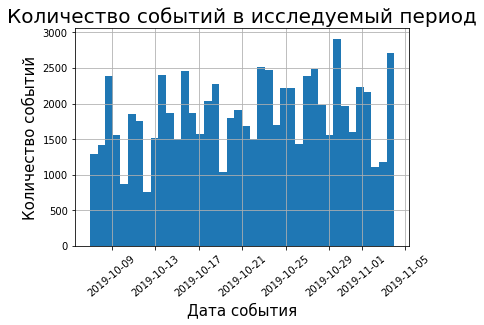

In [18]:
# построение гистограммы распределения числа событий по датам

mobile_dataset['event_time'].hist(bins=40)
plt.rcParams["figure.figsize"] = (10, 7)
plt.xticks(rotation=40)
plt.title('Количество событий в исследуемый период', fontsize=20)
plt.xlabel('Дата события', fontsize=15)
plt.ylabel('Количество событий', fontsize=15)
plt.show()

Самая ранняя дата в датасете это 00:00:00 7 октября 2019 года.


Самая поздняя дата в датасете это  23:58:13 3 ноября 2019 года.


Распределение событий по датам на всём протяжении исследуемого периода колеблется около значения 1500 событий в день. В отдельные дни число событий падает до значений 1000 событий в день и менее, в отдельные дни достигает значения 2500 событий в день и более.


Регулярность увеличения и снижения числа событий по дням не визуально наблюдается.

In [19]:
# выявление максимального и минимального количества событий для отдельного пользователя

mobile_dataset['user_id'].value_counts()

cb36854f-570a-41f4-baa8-36680b396370    478
e13f9f32-7ae3-4204-8d60-898db040bcfc    465
9ce63488-758a-481a-bcb5-a02b467e1d84    407
21230dd9-2f7f-4b77-a436-43d4d10388e0    400
be1449f6-ca45-4f94-93a7-ea4b079b8f0f    397
                                       ... 
c9087b41-3e83-4551-ae77-7a107f992052      1
3ac69839-e9d8-4cef-8306-9076e6358619      1
6a21a8dc-c9a6-49fa-a8e7-5a3cad431004      1
90aec49c-47f7-41ba-bc28-416855b51d6b      1
5bfdb95a-9d12-4436-b371-22754434d0d4      1
Name: user_id, Length: 4293, dtype: int64

In [20]:
# расчёт верхней границы выбросов значений числа событий (действий) пользователя в приложении

q1 = mobile_dataset['user_id'].value_counts().quantile(0.25)
q3 = mobile_dataset['user_id'].value_counts().quantile(0.75)
iqr = q3 - q1  
print('Верхняя граница количества событий, выше которой значения признаются выбросами:', 
      (q3 + 1.5 * iqr))

Верхняя граница количества событий, выше которой значения признаются выбросами: 35.0


In [21]:
# расчёт среднего числа событий (действий) пользователя в приложении

mobile_dataset['user_id'].value_counts().mean()

17.283251805264385

In [22]:
# расчёт медианного значения числа событий (действий) пользователя в приложении

mobile_dataset['user_id'].value_counts().median()

9.0

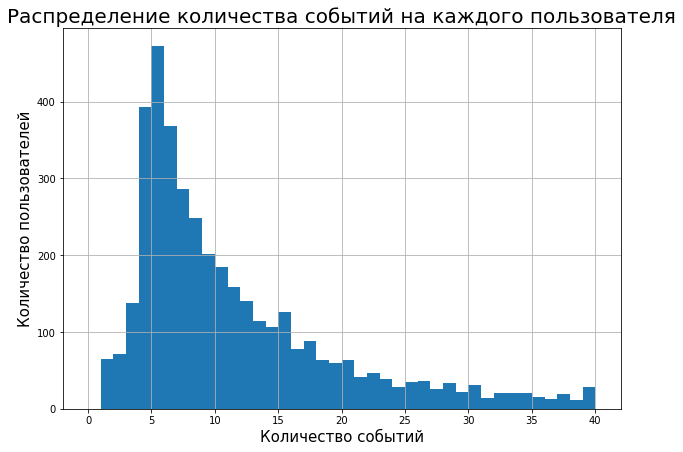

In [23]:
# визуализация распределения количества событий на каждого пользователя

mobile_dataset['user_id'].value_counts().hist(bins = 40, range = (0, 40))
plt.rcParams["figure.figsize"] = (10, 7)
plt.title('Распределение количества событий на каждого пользователя', fontsize=20)
plt.xlabel('Количество событий', fontsize=15)
plt.ylabel('Количество пользователей', fontsize=15)
plt.show()

В датасете содержатся id пользователей с различной активностью. Максимальное количество действий (событий), приходящееся на одного пользователя составляет 478. Часть пользователей совершили лишь одно действие (событие). 


Более 35 совершённых в приложении действий является необычным поведением пользователя. В среднем пользователь совершает 17 действий в приложении. Чаще всего пользователь в приложении совершает от 4 до 7 действий. Пользователей, совершивших в приложении лишь 1 действие невелико.


## 1.3 Объединение датасетов
Объединение датасетов методом merge() по столбцу user_id. 

In [24]:
# объединение датасетов методом merge() по столбцу user_id и вывод общего датасета

dataset = (
    mobile_dataset.merge(
        mobile_sources, left_on='user_id', right_on='user_id', how='left')
    )

display(dataset.head())
dataset.info()

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex


<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   source      74197 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.8+ MB


Объединённый датасет dataset содержит 74197 строк и 4 столбца без пропусков. Объединение прошло без потерь данных, все данные необходимого типа.


# 2 Сегментация 
Сегментирование - разбиение на две неравные группы пользователей по признаку их действий. Расчёт метрик, когортный анализ. Построение иллюстрирующих графиков. Выделение групп клиентов по расчитанным ранее метрикам. Описание характерных признаков и отличий пользовательских групп.
Расчёт метрик: retention rate, конверсия в просмотры контактов, время, проведённое в приложении клиентом, частота действий клиентов в приложении.

Сегментация пользователей приложения основывается на ранее определённым аномально большом числе событий:

* toomuch_events - пользователи, совершившие более 35-ти событий;


* medium_events - пользователи, совершившие 35 и менее событий.


Выбор критерия "число совершённых пользователем событий в приложении" для сегментирования пользователеей на группы обусловлен вопросом: не являются ли все эти избыточные (с т.з. распределения количества действий среди пользователей)  действия пользователей в приложении бесцельным блужданием, праздным нажатием кнопок и просмотром фотографий ради рассматривания фотографий, не приводящими к полезным действиям?


----------------

Для удобства рассчётов рассматриваются недельные когорты и лайфтаймы.

In [25]:
# подсчёт количества событий каждым уникальным пользователем

profilesn = (
    dataset
        .sort_values(by=['user_id', 'event_name'])
        .groupby('user_id')
        .agg({'event_name':'count'})
        .rename(columns={'event_name':'number_events'})
        .reset_index()
)

profilesn

,user_id,number_events
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35
1,00157779-810c-4498-9e05-a1e9e3cedf93,71
2,00463033-5717-4bf1-91b4-09183923b9df,10
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32
4,00551e79-152e-4441-9cf7-565d7eb04090,8
...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,17
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,7
4290,ffcf50d9-293c-4254-8243-4890b030b238,2
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,13


In [26]:
# добавление результатов предыдущего шага к общему датасету

dataset_n = dataset.merge(profilesn, on='user_id')   

dataset_n

,event_time,event_name,user_id,source,number_events
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,28
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,28
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,28
3,2019-10-07 00:01:28,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,28
4,2019-10-07 00:01:35,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,28
...,...,...,...,...,...
74192,2019-11-03 23:46:47,map,d157bffc-264d-4464-8220-1cc0c42f43a9,google,5
74193,2019-11-03 23:46:59,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google,5
74194,2019-11-03 23:47:01,tips_show,d157bffc-264d-4464-8220-1cc0c42f43a9,google,5
74195,2019-11-03 23:47:47,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google,5


In [27]:
# формирование первой группы пользователей - пользователи, совершившие более 35-ти событий

toomuch_events= dataset_n.query('number_events > 35')
toomuch_events['event_week'] = toomuch_events['event_time'].dt.week
toomuch_events

,event_time,event_name,user_id,source,number_events,event_week
28,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41
29,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41
30,2019-10-07 00:01:20,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41
31,2019-10-07 00:01:50,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41
32,2019-10-07 00:02:06,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41
...,...,...,...,...,...,...
73972,2019-11-03 23:21:53,tips_show,a0944ccf-5813-427a-966e-b146d4e9adbc,google,39,44
73973,2019-11-03 23:22:00,tips_show,a0944ccf-5813-427a-966e-b146d4e9adbc,google,39,44
73974,2019-11-03 23:44:13,show_contacts,a0944ccf-5813-427a-966e-b146d4e9adbc,google,39,44
73975,2019-11-03 23:44:29,tips_show,a0944ccf-5813-427a-966e-b146d4e9adbc,google,39,44


In [28]:
# формирование второй группы пользователей - пользователи, совершившие 35 и менее событий

medium_events = dataset_n.query('number_events <= 35')
medium_events['event_week'] = medium_events['event_time'].dt.week
medium_events

,event_time,event_name,user_id,source,number_events,event_week
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41
3,2019-10-07 00:01:28,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41
4,2019-10-07 00:01:35,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41
...,...,...,...,...,...,...
74192,2019-11-03 23:46:47,map,d157bffc-264d-4464-8220-1cc0c42f43a9,google,5,44
74193,2019-11-03 23:46:59,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google,5,44
74194,2019-11-03 23:47:01,tips_show,d157bffc-264d-4464-8220-1cc0c42f43a9,google,5,44
74195,2019-11-03 23:47:47,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google,5,44


Исходный датасет поделился с небольшим численным перевесом пользователей, совершивших 35 и менее событий.


Далее рассчитываю метрики для каждого выделенного сегмента пользователей.


Первый расчёт для сегмента toomuch_events.

In [29]:
# формирование таблицы профилей пользователей, совершивших более 35 событий

profiles_toomuch = (
    toomuch_events
        .sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg({'event_time':'first', 'source':'first'})
        .rename(columns={'event_time':'first_ts'})
        .assign(dt=lambda x: x['first_ts'].dt.week)
        .reset_index()
)

profiles_toomuch

,user_id,first_ts,source,dt
0,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:34,yandex,42
1,017c6afc-965d-4c94-84ee-f0e326998e30,2019-10-10 14:28:11,other,41
2,02c90994-8de8-49e8-a384-415fb1602ac5,2019-10-14 23:07:14,other,42
3,04adf25e-cb60-4cbd-bedc-ddc1057cde06,2019-10-13 15:41:09,other,41
4,04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791,2019-10-26 15:36:03,yandex,43
...,...,...,...,...
429,fdd232f5-962d-4eed-ac02-f0141385cc8f,2019-10-08 11:30:15,yandex,41
430,feb7c7a1-26e0-4ea9-9cdc-3e5b401cac97,2019-10-17 11:22:27,yandex,42
431,fee3ba1c-16f4-46f7-bf56-4bf80cc4e2f5,2019-10-26 11:43:12,google,43
432,ff82c7c7-16d6-44b1-833b-a217747b0b02,2019-10-15 23:41:08,yandex,42


In [30]:
# объединение таблицы профилей с датастетом с логами

rt_toomuch = toomuch_events.merge(profiles_toomuch, on='user_id')

rt_toomuch.head()

,event_time,event_name,user_id,source_x,number_events,event_week,first_ts,source_y,dt
0,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41,2019-10-07 00:00:02,yandex,41
1,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41,2019-10-07 00:00:02,yandex,41
2,2019-10-07 00:01:20,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41,2019-10-07 00:00:02,yandex,41
3,2019-10-07 00:01:50,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41,2019-10-07 00:00:02,yandex,41
4,2019-10-07 00:02:06,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41,2019-10-07 00:00:02,yandex,41


In [31]:
# расчёт лайфтайма

rt_toomuch['lifetime'] = rt_toomuch['event_week'] - rt_toomuch['dt']

rt_toomuch.head()

,event_time,event_name,user_id,source_x,number_events,event_week,first_ts,source_y,dt,lifetime
0,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41,2019-10-07 00:00:02,yandex,41,0
1,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41,2019-10-07 00:00:02,yandex,41,0
2,2019-10-07 00:01:20,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41,2019-10-07 00:00:02,yandex,41,0
3,2019-10-07 00:01:50,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41,2019-10-07 00:00:02,yandex,41,0
4,2019-10-07 00:02:06,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41,2019-10-07 00:00:02,yandex,41,0


In [32]:
# формирование сводной таблицы

rtt_toomuch = rt_toomuch.pivot_table(
    index = 'dt',
    columns = 'lifetime',
    values = 'user_id',
    aggfunc = 'nunique'
)

rtt_toomuch

lifetime,0,1,2,3
dt,,,,
41,154.0,92.0,63.0,53.0
42,129.0,80.0,44.0,NaN
43,101.0,58.0,NaN,NaN
44,50.0,NaN,NaN,NaN


In [33]:
# расчёт retention rate

rtt_toomuch.div(rtt_toomuch[0], axis=0)

lifetime,0,1,2,3
dt,,,,
41,1.0,0.597403,0.409091,0.344156
42,1.0,0.620155,0.341085,NaN
43,1.0,0.574257,NaN,NaN
44,1.0,NaN,NaN,NaN


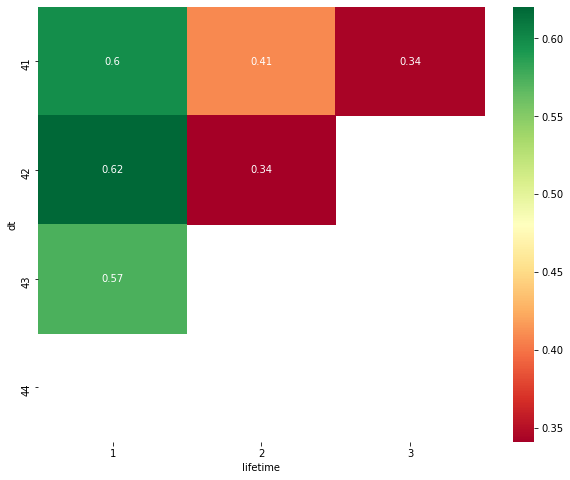

In [34]:
# визуализация результата предыдущего шага

plt.figure(figsize = (10, 8))
sns.heatmap(rtt_toomuch.div(rtt_toomuch[0], axis=0).drop(columns = [0]), annot = True, cmap = 'RdYlGn')
plt.show()

Значения Retention Rate (коэффициента удержания) для первого лайфтайма (периода) составляют: 0,6; 0,62; 0,57. 

Среднее значение Retention Rate для сегмента пользователей, совершивших более 35 событий (действий) составляет 59,7%.


In [35]:
# формирование таблицы профилей пользователей, совершивших 35 и менее событий

profiles_medium = (
    medium_events
        .sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg({'event_time':'first', 'source':'first'})
        .rename(columns={'event_time':'first_ts'})
        .assign(dt=lambda x: x['first_ts'].dt.week)
        .reset_index()
)

profiles_medium

,user_id,first_ts,source,dt
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:46,other,41
1,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35,yandex,44
2,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:06,google,42
3,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41,yandex,43
4,00554293-7e00-4122-b898-4e892c4a7c53,2019-10-27 12:32:28,yandex,43
...,...,...,...,...
3854,ff5c152c-bd63-4797-8fa2-29987199e76d,2019-10-17 12:25:14,yandex,42
3855,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2019-10-13 16:11:27,yandex,41
3856,ffc01466-fdb1-4460-ae94-e800f52eb136,2019-10-07 20:32:50,yandex,41
3857,ffcf50d9-293c-4254-8243-4890b030b238,2019-10-23 11:51:35,google,43


In [36]:
# объединение таблицы профилей с датастетом с логами

rt_medium = medium_events.merge(profiles_medium, on='user_id')

rt_medium.head()

,event_time,event_name,user_id,source_x,number_events,event_week,first_ts,source_y,dt
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41,2019-10-07,other,41
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41,2019-10-07,other,41
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41,2019-10-07,other,41
3,2019-10-07 00:01:28,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41,2019-10-07,other,41
4,2019-10-07 00:01:35,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41,2019-10-07,other,41


In [37]:
# расчёт лайфтайма

rt_medium['lifetime'] = rt_medium['event_week'] - rt_medium['dt']

rt_medium.head()

,event_time,event_name,user_id,source_x,number_events,event_week,first_ts,source_y,dt,lifetime
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41,2019-10-07,other,41,0
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41,2019-10-07,other,41,0
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41,2019-10-07,other,41,0
3,2019-10-07 00:01:28,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41,2019-10-07,other,41,0
4,2019-10-07 00:01:35,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41,2019-10-07,other,41,0


In [38]:
# формирование сводной таблицы

rtt_medium = rt_medium.pivot_table(
    index = 'dt',
    columns = 'lifetime',
    values = 'user_id',
    aggfunc = 'nunique'
)

rtt_medium

lifetime,0,1,2,3
dt,,,,
41,976.0,180.0,107.0,66.0
42,1037.0,202.0,111.0,NaN
43,993.0,181.0,NaN,NaN
44,853.0,NaN,NaN,NaN


In [39]:
# расчёт retention rate

rtt_medium.div(rtt_medium[0], axis=0)

lifetime,0,1,2,3
dt,,,,
41,1.0,0.184426,0.109631,0.067623
42,1.0,0.194793,0.107040,NaN
43,1.0,0.182276,NaN,NaN
44,1.0,NaN,NaN,NaN


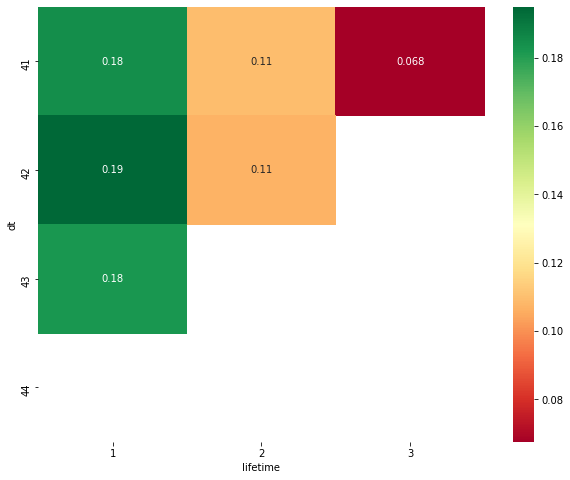

In [40]:
# визуализация результата предыдущего шага

plt.figure(figsize = (10, 8))
sns.heatmap(rtt_medium.div(rtt_medium[0], axis=0).drop(columns = [0]), annot = True, cmap = 'RdYlGn')
plt.show()

Значения Retention Rate (коэффициента удержания) для первого лайфтайма (периода) составляют: 0,18; 0,19; 0,18. 

Среднее значение Retention Rate для сегмента пользователей, совершивших 35 и менее событий (действий) составляет 18,3%.


Расчёт Retention Rate (коэффициента удержания) показал, что пользователи, совершающие необычно много действий в приложении удерживаются значительно сильнее по сравнению с пользователями, совершающими обычное число (менее 35-ти) действий.

------------------------------------

Далее следует расчёт конверсии в целевое действие. Целевым действием является: show_contacts - пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления.


Сначала расчёт для сегмента пользователей toomuch_events.

In [41]:
# формирование таблицы логов пользователей впервые совершивших действие "пользователь нажал на кнопку 
# "посмотреть номер телефона" на карточке объявления" среди пользователей, 
# совершивших более 35 событий

contacts_toomuch = (
    toomuch_events.query('event_name == "show_contacts"')
        .sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg({'event_time':'first', 'source':'first'})
        .rename(columns={'event_time':'first_view'})
        .reset_index()
)

contacts_toomuch

,user_id,first_view,source
0,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 19:17:19,yandex
1,04adf25e-cb60-4cbd-bedc-ddc1057cde06,2019-10-13 17:37:33,other
2,04e06319-c049-465c-9170-362a191a1287,2019-10-17 11:03:24,yandex
3,06216934-8394-482e-a9fd-001f93bbebde,2019-10-17 16:30:20,google
4,06bdb96e-2712-47b3-a0af-d19f297abd6c,2019-10-12 17:52:29,yandex
...,...,...,...
179,f9e48f0a-b7b3-452b-9018-0d1e1574b9f5,2019-10-24 14:50:17,yandex
180,fd33e787-85c8-4c53-99bd-3439f676fb40,2019-10-29 02:22:10,other
181,fdd232f5-962d-4eed-ac02-f0141385cc8f,2019-10-10 16:52:22,yandex
182,fee3ba1c-16f4-46f7-bf56-4bf80cc4e2f5,2019-10-26 12:13:20,google


In [42]:
# объединение таблицы профилей с датастетом логов contacts_viewers

cr_toomuch = profiles_toomuch.merge(contacts_toomuch, on = 'user_id', how = 'left')
cr_toomuch['first_week'] = cr_toomuch['first_view'].dt.week
cr_toomuch.head()

,user_id,first_ts,source_x,dt,first_view,source_y,first_week
0,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:34,yandex,42,2019-10-20 19:17:19,yandex,42.0
1,017c6afc-965d-4c94-84ee-f0e326998e30,2019-10-10 14:28:11,other,41,NaT,NaN,NaN
2,02c90994-8de8-49e8-a384-415fb1602ac5,2019-10-14 23:07:14,other,42,NaT,NaN,NaN
3,04adf25e-cb60-4cbd-bedc-ddc1057cde06,2019-10-13 15:41:09,other,41,2019-10-13 17:37:33,other,41.0
4,04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791,2019-10-26 15:36:03,yandex,43,NaT,NaN,NaN


In [43]:
# вычисление лайфтайма - количества дней, прошедших со дня первого посещения приложения до дня 
# совершения show_contacts (просмотра контактов)

cr_toomuch['lifetime'] = cr_toomuch['first_week'] - cr_toomuch['dt']

cr_toomuch.head()

,user_id,first_ts,source_x,dt,first_view,source_y,first_week,lifetime
0,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:34,yandex,42,2019-10-20 19:17:19,yandex,42.0,0.0
1,017c6afc-965d-4c94-84ee-f0e326998e30,2019-10-10 14:28:11,other,41,NaT,NaN,NaN,NaN
2,02c90994-8de8-49e8-a384-415fb1602ac5,2019-10-14 23:07:14,other,42,NaT,NaN,NaN,NaN
3,04adf25e-cb60-4cbd-bedc-ddc1057cde06,2019-10-13 15:41:09,other,41,2019-10-13 17:37:33,other,41.0,0.0
4,04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791,2019-10-26 15:36:03,yandex,43,NaT,NaN,NaN,NaN


In [44]:
# формирование сводной таблицы конверсии в целевое действие

crr_toomuch = cr_toomuch.pivot_table(
    index = 'dt',
    columns = 'lifetime',
    values = 'first_week',
    aggfunc = 'count'
)

crr_toomuch

lifetime,0.0,1.0,2.0,3.0
dt,,,,
41,47.0,15.0,4.0,1.0
42,35.0,7.0,5.0,NaN
43,41.0,7.0,NaN,NaN
44,22.0,NaN,NaN,NaN


In [45]:
# переформатирование конверсии в кумулятивную конверсию

cumcrr_toomuch = crr_toomuch.cumsum(axis = 1)
cumcrr_toomuch

lifetime,0.0,1.0,2.0,3.0
dt,,,,
41,47.0,62.0,66.0,67.0
42,35.0,42.0,47.0,NaN
43,41.0,48.0,NaN,NaN
44,22.0,NaN,NaN,NaN


In [46]:
# расчёт размера когорт пользователей приложения

sizes_toomuch = profiles_toomuch.groupby('dt')['user_id'].count()
sizes_toomuch

dt
41    154
42    129
43    101
44     50
Name: user_id, dtype: int64

In [47]:
# расчёт кумулятивной конверсии в целевое действие в долях

cumcrr_toomuch.div(sizes_toomuch, axis = 0)

lifetime,0.0,1.0,2.0,3.0
dt,,,,
41,0.305195,0.402597,0.428571,0.435065
42,0.271318,0.325581,0.364341,NaN
43,0.405941,0.475248,NaN,NaN
44,0.440000,NaN,NaN,NaN


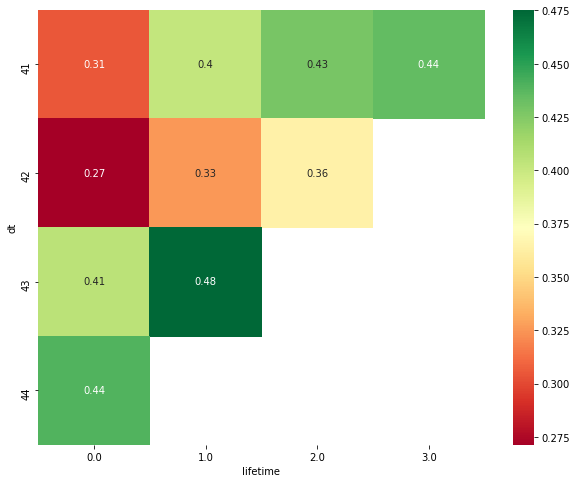

In [48]:
# визуализация результата предыдущего шага

plt.figure(figsize = (10, 8))
sns.heatmap(cumcrr_toomuch.div(sizes_toomuch, axis = 0), annot = True, cmap = 'RdYlGn')
plt.show()

Значения CR (конверсии в целевое действие) для первого лайфтайма (периода) составляют: 0,31; 0,27; 0,41; 0,44. 

Среднее значение CR для сегмента пользователей, совершивших более 35-ти событий (действий) составляет 35,75%.


In [49]:
# формирование таблицы логов пользователей впервые совершивших действие "пользователь нажал на кнопку 
# "посмотреть номер телефона" на карточке объявления" среди пользователей, 
# совершивших 35 и менее событий

contacts_medium = (
    medium_events.query('event_name == "show_contacts"')
        .sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg({'event_time':'first', 'source':'first'})
        .rename(columns={'event_time':'first_view'})
        .reset_index()
)

contacts_medium

,user_id,first_view,source
0,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41,yandex
1,005fbea5-2678-406f-88a6-fbe9787e2268,2019-10-11 11:22:54,yandex
2,00753c79-ea81-4456-acd0-a47a23ca2fb9,2019-10-20 14:57:06,yandex
3,007d031d-5018-4e02-b7ee-72a30609173f,2019-10-22 13:08:09,yandex
4,00a93a72-3bbc-4ee7-8a81-7134f45ae009,2019-10-11 15:38:13,google
...,...,...,...
792,fda0d8ef-8cbf-4b3a-af44-8f4034bd9cc5,2019-10-17 22:06:36,google
793,fdaffa89-8eb4-4908-beba-2b40deb53346,2019-10-30 18:12:07,google
794,ff1554b5-919e-40b1-90bb-ee1f7f6d5846,2019-10-21 10:59:24,other
795,ffc01466-fdb1-4460-ae94-e800f52eb136,2019-10-07 20:33:42,yandex


In [50]:
# объединение таблицы профилей с датастетом логов contacts_viewers

cr_medium = profiles_medium.merge(contacts_medium, on = 'user_id', how = 'left')
cr_medium['first_week'] = cr_medium['first_view'].dt.week
cr_medium.head()

,user_id,first_ts,source_x,dt,first_view,source_y,first_week
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:46,other,41,NaT,NaN,NaN
1,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35,yandex,44,NaT,NaN,NaN
2,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:06,google,42,NaT,NaN,NaN
3,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41,yandex,43,2019-10-25 16:44:41,yandex,43.0
4,00554293-7e00-4122-b898-4e892c4a7c53,2019-10-27 12:32:28,yandex,43,NaT,NaN,NaN


In [51]:
# вычисление лайфтайма - количества дней, прошедших со дня первого посещения приложения до дня 
# совершения show_contacts (просмотра контактов)

cr_medium['lifetime'] = cr_medium['first_week'] - cr_medium['dt']

cr_medium.head()

,user_id,first_ts,source_x,dt,first_view,source_y,first_week,lifetime
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:46,other,41,NaT,NaN,NaN,NaN
1,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35,yandex,44,NaT,NaN,NaN,NaN
2,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:06,google,42,NaT,NaN,NaN,NaN
3,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41,yandex,43,2019-10-25 16:44:41,yandex,43.0,0.0
4,00554293-7e00-4122-b898-4e892c4a7c53,2019-10-27 12:32:28,yandex,43,NaT,NaN,NaN,NaN


In [52]:
# формирование сводной таблицы конверсии в целевое действие

crr_medium = cr_medium.pivot_table(
    index = 'dt',
    columns = 'lifetime',
    values = 'first_week',
    aggfunc = 'count'
)

crr_medium

lifetime,0.0,1.0,2.0,3.0
dt,,,,
41,171.0,22.0,9.0,3.0
42,186.0,15.0,5.0,NaN
43,187.0,33.0,NaN,NaN
44,166.0,NaN,NaN,NaN


In [53]:
# переформатирование конверсии в кумулятивную конверсию

cumcrr_medium = crr_medium.cumsum(axis = 1)
cumcrr_medium

lifetime,0.0,1.0,2.0,3.0
dt,,,,
41,171.0,193.0,202.0,205.0
42,186.0,201.0,206.0,NaN
43,187.0,220.0,NaN,NaN
44,166.0,NaN,NaN,NaN


In [54]:
# расчёт размера когорт пользователей приложения

sizes_medium = profiles_medium.groupby('dt')['user_id'].count()
sizes_medium

dt
41     976
42    1037
43     993
44     853
Name: user_id, dtype: int64

In [55]:
# расчёт кумулятивной конверсии в целевое действие в долях

cumcrr_medium.div(sizes_medium, axis = 0)

lifetime,0.0,1.0,2.0,3.0
dt,,,,
41,0.175205,0.197746,0.206967,0.210041
42,0.179364,0.193828,0.198650,NaN
43,0.188318,0.221551,NaN,NaN
44,0.194607,NaN,NaN,NaN


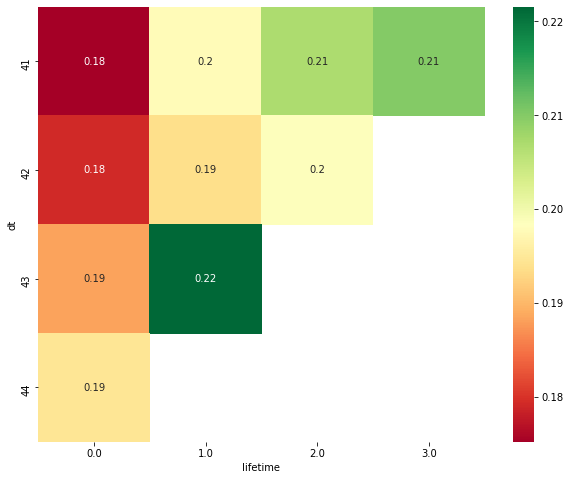

In [56]:
# визуализация результата предыдущего шага

plt.figure(figsize = (10, 8))
sns.heatmap(cumcrr_medium.div(sizes_medium, axis = 0), annot = True, cmap = 'RdYlGn')
plt.show()

Значения CR (конверсии в целевое действие) для первого лайфтайма (периода) составляют: 0,18; 0,18; 0,19; 0,19. 

Среднее значение CR для сегмента пользователей, совершивших 35 и менее событий (действий) составляет 18,5%.

Расчёт CR (конверсии в целевое действие) показал, что пользователи, совершающие необычно много действий в приложении совершают целевое действие значительно чаще по сравнению с пользователями, совершающими обычное число (менее 35-ти) действий.


---------------------------------

Далее следует расчёт длительности пользовательских сессий, т.е., время, проведённое пользователями в приложении. 


Для отделения сессий друг от друга принимаю временной промежуток между сессиями 30 минут. Это значит, что если пользователь не совершал никаких действий более 30 минут, то следующее действие было совершено в следующую сессию.


Сначала расчёт для сегмента пользователей toomuch_events.

In [57]:
# разделение сессий с учётом максимального перерыва между действиями в сессии не более 30 минут

g_toomuch = (toomuch_events.groupby('user_id')['event_time'].diff() > pd.Timedelta('30Min')).cumsum()

toomuch_events['session_id'] = toomuch_events.groupby(['user_id', g_toomuch], sort=False).ngroup() + 1

# вывод большого числа строк для визуального контроля отделения сессий 

toomuch_events.head()

,event_time,event_name,user_id,source,number_events,event_week,session_id
28,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41,1
29,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41,1
30,2019-10-07 00:01:20,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41,1
31,2019-10-07 00:01:50,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41,1
32,2019-10-07 00:02:06,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41,1


In [58]:
# вычисление времени начала сессий

s_toomuch = toomuch_events.groupby('session_id').agg({'event_time' : 'min'}).reset_index()
s_toomuch= s_toomuch.rename(columns={'event_time': 'start_session'}) 
s_toomuch.head(3)

,session_id,start_session
0,1,2019-10-07 00:00:02
1,2,2019-10-08 20:06:42
2,3,2019-10-10 19:43:23


In [59]:
# вычисление времени окончания сессий

e_toomuch = toomuch_events.groupby('session_id').agg({'event_time' : 'max'}).reset_index()
e_toomuch = e_toomuch.rename(columns={'event_time': 'end_session'}) 
e_toomuch.head(3)

,session_id,end_session
0,1,2019-10-07 00:41:40
1,2,2019-10-08 20:19:08
2,3,2019-10-10 20:12:33


In [60]:
# объединение датафреймов, содержащих даты начала и окончания сессий

toomuch_sessions = s_toomuch.merge(e_toomuch, on = 'session_id')

toomuch_sessions.head(3)

,session_id,start_session,end_session
0,1,2019-10-07 00:00:02,2019-10-07 00:41:40
1,2,2019-10-08 20:06:42,2019-10-08 20:19:08
2,3,2019-10-10 19:43:23,2019-10-10 20:12:33


In [61]:
# вычисление длительности сессий в секундах

toomuch_sessions['dur_sess'] = toomuch_sessions['end_session'] - toomuch_sessions['start_session']
toomuch_sessions['dur_sess'] = toomuch_sessions['dur_sess'].dt.seconds

toomuch_sessions.head(3)

,session_id,start_session,end_session,dur_sess
0,1,2019-10-07 00:00:02,2019-10-07 00:41:40,2498
1,2,2019-10-08 20:06:42,2019-10-08 20:19:08,746
2,3,2019-10-10 19:43:23,2019-10-10 20:12:33,1750


In [62]:
# просмотр агрегированных данных колонки с длительностью сессий пользователей

toomuch_sessions['dur_sess'].describe()

count     3167.000000
mean      1129.418693
std       1679.057121
min          0.000000
25%         27.000000
50%        474.000000
75%       1526.000000
max      19318.000000
Name: dur_sess, dtype: float64

In [63]:
# вывод строчек датафрейма с необычно длительными сессиями (более трёх часов), 
# контроль на предмет ошибок

very_toomuch = toomuch_sessions.query('dur_sess > 10800')

very_toomuch

,session_id,start_session,end_session,dur_sess
70,71,2019-10-08 11:31:49,2019-10-08 15:01:44,12595
317,318,2019-10-08 10:47:17,2019-10-08 15:06:46,15569
369,370,2019-11-01 10:24:05,2019-11-01 13:42:03,11878
783,784,2019-10-11 11:24:21,2019-10-11 16:46:19,19318
1013,1014,2019-10-29 14:13:49,2019-10-29 17:19:48,11159
1267,1268,2019-10-12 19:11:40,2019-10-12 22:40:46,12546
1269,1270,2019-10-13 13:44:01,2019-10-13 17:37:40,14019
1273,1274,2019-11-02 19:46:32,2019-11-02 22:46:36,10804
2823,2824,2019-10-26 15:36:03,2019-10-26 19:08:10,12727
2891,2892,2019-10-27 01:24:21,2019-10-27 04:36:45,11544


Расчёт длительности сессий в сегменте toomuch_events - пользователи, совершившие более 35-ти событий дал следующие результаты (с учётом предыдущих рассчётов):


* 434 пользователя совершили в приложении за исследуемый период 3167 сессий;


* средняя продолжительность сессии составляет 1129 секунд или почти 19 минут;


* часть пользователей совершает очень длительные сессии,- например, 10 сессий длилось более трёх часов, а максимальная сессия длилась более пяти часов.


In [64]:
# разделение сессий с учётом максимального перерыва между действиями в сессии не более 30 минут

g_medium = (medium_events.groupby('user_id')['event_time'].diff() > pd.Timedelta('30Min')).cumsum()

medium_events['session_id'] = medium_events.groupby(['user_id', g_medium], sort=False).ngroup() + 1

# вывод большого числа строк для визуального контроля отделения сессий 

medium_events.head()

,event_time,event_name,user_id,source,number_events,event_week,session_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41,1
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41,1
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41,1
3,2019-10-07 00:01:28,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41,1
4,2019-10-07 00:01:35,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,28,41,1


In [65]:
# вычисление времени начала сессий

s_medium = medium_events.groupby('session_id').agg({'event_time' : 'min'}).reset_index()
s_medium = s_medium.rename(columns={'event_time': 'start_session'}) 
s_medium.head(3)

,session_id,start_session
0,1,2019-10-07 00:00:00
1,2,2019-10-07 00:05:20
2,3,2019-10-10 15:45:36


In [66]:
# вычисление времени окончания сессий

e_medium = medium_events.groupby('session_id').agg({'event_time' : 'max'}).reset_index()
e_medium = e_medium.rename(columns={'event_time': 'end_session'}) 
e_medium.head(3)

,session_id,end_session
0,1,2019-10-07 00:18:43
1,2,2019-10-07 00:05:23
2,3,2019-10-10 15:47:43


In [67]:
# объединение датафреймов, содержащих даты начала и окончания сессий

medium_sessions = s_medium.merge(e_medium, on = 'session_id')

medium_sessions.head(3)

,session_id,start_session,end_session
0,1,2019-10-07 00:00:00,2019-10-07 00:18:43
1,2,2019-10-07 00:05:20,2019-10-07 00:05:23
2,3,2019-10-10 15:45:36,2019-10-10 15:47:43


In [68]:
# вычисление длительности сессий в секундах

medium_sessions['dur_sess'] = medium_sessions['end_session'] - medium_sessions['start_session']
medium_sessions['dur_sess'] = medium_sessions['dur_sess'].dt.seconds

medium_sessions.head(3)

,session_id,start_session,end_session,dur_sess
0,1,2019-10-07 00:00:00,2019-10-07 00:18:43,1123
1,2,2019-10-07 00:05:20,2019-10-07 00:05:23,3
2,3,2019-10-10 15:45:36,2019-10-10 15:47:43,127


In [69]:
medium_sessions['dur_sess'].describe()

count     7201.000000
mean       615.770449
std        851.011232
min          0.000000
25%         18.000000
50%        297.000000
75%        865.000000
max      13050.000000
Name: dur_sess, dtype: float64

In [70]:
very_medium = medium_sessions.query('dur_sess > 10800')

very_medium

,session_id,start_session,end_session,dur_sess
249,250,2019-10-07 19:54:24,2019-10-07 23:31:54,13050


Расчёт длительности сессий в сегменте medium_events - пользователи, совершившие 35 и менее событий дал следующие результаты (с учётом предыдущих рассчётов):


* 3859 пользователей совершили в приложении за исследуемый период 7201 сессию;


* средняя продолжительность сессии составляет 615 секунд или чуть больше 10 минут;


* только одна сессия пользователя этого сегмента длилась более трёх часов.




----------------------------

Далее следует расчёт частоты действий пользователя во время сессии. 


Методика расчёта: среднее число действий пользователя за все сессии на протяжении исследуемого периода.


In [71]:
# расчёт частоты действий пользователей сегмента toomuch_events в приложении 

toomuch_freq = round(toomuch_events['session_id'].count() / toomuch_events['session_id'].max(), 1)
print('В среднем пользователи сегмента toomuch_events совершают', toomuch_freq,
      'действий за одну сессию') 

В среднем пользователи сегмента toomuch_events совершают 10.6 действий за одну сессию


In [72]:
# расчёт частоты действий пользователей сегмента medium_events в приложении

medium_freq = round(medium_events['session_id'].count() / medium_events['session_id'].max(), 1)
print('В среднем пользователи сегмента toomuch_events совершают', medium_freq,
      'действий за одну сессию')

В среднем пользователи сегмента toomuch_events совершают 5.6 действий за одну сессию


В дополнение к расчитанным метрикам далее расчёт пользовательской активности — количество уникальных активных пользователей за определённое время.

    • DAU — количество уникальных пользователей в день;
    • WAU — количество уникальных пользователей в неделю.


In [73]:
# выделение календарной даты без времени

toomuch_events['date_time'] = toomuch_events['event_time'].dt.date
toomuch_events['date_time'].head(2)

28    2019-10-07
29    2019-10-07
Name: date_time, dtype: object

In [74]:
# расчёт показателей DAU и WAU для пользователей сегмента toomuch_events

dau_toomuch = toomuch_events.groupby('date_time').agg({'user_id': 'nunique'}).mean()

wau_toomuch = toomuch_events.groupby('event_week').agg({'user_id': 'nunique'}).mean()


print(int(dau_toomuch))
print(int(wau_toomuch))

67
206


In [75]:
# выделение календарной даты без времени

medium_events['date_time'] = medium_events['event_time'].dt.date
medium_events['date_time'].head(2)

0    2019-10-07
1    2019-10-07
Name: date_time, dtype: object

In [76]:
# расчёт показателей DAU и WAU для пользователей сегмента medium_events

dau_medium = medium_events.groupby('date_time').agg({'user_id': 'nunique'}).mean()

wau_medium = medium_events.groupby('event_week').agg({'user_id': 'nunique'}).mean()


print(int(dau_medium))
print(int(wau_medium))

212
1176


-------------------------

Вычисление времени между первым действием пользователя в приложении до любого действия из списка событий search_1  —  search_7.


In [98]:
# формирование среза со всеми событиями из списка событий search_1 — search_7
# сегмент пользователей toomuch_events

toomuch_events_ser = toomuch_events.query('event_name == "search_1" or event_name == "search_2"\
    or event_name == "search_3" or event_name == "search_4" or event_name == "search_5"\
    or event_name == "search_6" or event_name == "search_7"')                                                                                 
                                                                                 
toomuch_events_ser.head(3)

,event_time,event_name,user_id,source,number_events,event_week,session_id,date_time
55,2019-10-08 20:08:11,search_4,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,41,2,2019-10-08
86,2019-10-16 21:36:12,search_2,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,42,4,2019-10-16
87,2019-10-16 21:36:12,search_4,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,93,42,4,2019-10-16


In [97]:
# вычисление времени начала использования поиска - самого раннего из списка событий search_1 — search_7

e_toomuch_ser = toomuch_events_ser.groupby('session_id').agg({'event_time' : 'min'}).reset_index()
e_toomuch_ser = e_toomuch_ser.rename(columns={'event_time': 'start_search'}) 
e_toomuch_ser.head(3)

,session_id,start_search
0,2,2019-10-08 20:08:11
1,4,2019-10-16 21:36:12
2,9,2019-10-17 21:48:10


In [91]:
# объединение датафреймов, содержащих даты начала сессий и начала использования поиска

toomuch_sessions_ser = s_toomuch.merge(e_toomuch_ser, on = 'session_id')

toomuch_sessions_ser.head(3)

,session_id,start_session,start_search
0,2,2019-10-08 20:06:42,2019-10-08 20:08:11
1,4,2019-10-16 21:17:07,2019-10-16 21:36:12
2,9,2019-10-17 21:48:10,2019-10-17 21:48:10


In [103]:
# вычисление длительности временного промежутка между началом сессий и началом использования 
# поиска в секундах

toomuch_sessions_ser['dur_gap'] = toomuch_sessions_ser['start_search'] - \
                                                            toomuch_sessions_ser['start_session']
toomuch_sessions_ser['dur_gap'] = toomuch_sessions_ser['dur_gap'].dt.seconds

toomuch_sessions_ser.head(3)

,session_id,start_session,start_search,dur_gap
0,2,2019-10-08 20:06:42,2019-10-08 20:08:11,89
1,4,2019-10-16 21:17:07,2019-10-16 21:36:12,1145
2,9,2019-10-17 21:48:10,2019-10-17 21:48:10,0


In [94]:
# просмотр агрегированных данных о длительности временного промежутка между началом сессий 
# и началом использования поиска

toomuch_sessions_ser['dur_gap'].describe()

count     838.000000
mean      194.125298
std       665.256611
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      7084.000000
Name: dur_gap, dtype: float64

In [99]:
# формирование среза со всеми событиями из списка событий search_1 — search_7
# сегмент пользователей medium_events

medium_events_ser = medium_events.query('event_name == "search_1" or event_name == "search_2"\
    or event_name == "search_3" or event_name == "search_4" or event_name == "search_5"\
    or event_name == "search_6" or event_name == "search_7"')                                                                                 
                                                                                 
medium_events_ser.head(3)

,event_time,event_name,user_id,source,number_events,event_week,session_id,date_time
217,2019-10-07 00:05:20,search_4,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other,8,41,2,2019-10-07
218,2019-10-07 00:05:23,search_5,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other,8,41,2,2019-10-07
380,2019-10-30 21:37:16,search_4,57321726-5d66-4d51-84f4-c797c35dcf2b,google,6,44,8,2019-10-30


In [100]:
# вычисление времени начала использования поиска - самого раннего из списка событий search_1 — search_7

e_medium_ser = medium_events_ser.groupby('session_id').agg({'event_time' : 'min'}).reset_index()
e_medium_ser = e_medium_ser.rename(columns={'event_time': 'start_search'}) 
e_medium_ser.head(3)

,session_id,start_search
0,2,2019-10-07 00:05:20
1,8,2019-10-30 21:37:16
2,10,2019-10-07 08:10:01


In [101]:
# объединение датафреймов, содержащих даты начала сессий и начала использования поиска

medium_sessions_ser = s_medium.merge(e_medium_ser, on = 'session_id')

medium_sessions_ser.head(3)

,session_id,start_session,start_search
0,2,2019-10-07 00:05:20,2019-10-07 00:05:20
1,8,2019-10-30 21:37:16,2019-10-30 21:37:16
2,10,2019-10-07 08:02:58,2019-10-07 08:10:01


In [104]:
# вычисление длительности временного промежутка между началом сессий и началом использования 
# поиска в секундах

medium_sessions_ser['dur_gap'] = medium_sessions_ser['start_search'] - \
                                                            medium_sessions_ser['start_session']
medium_sessions_ser['dur_gap'] = medium_sessions_ser['dur_gap'].dt.seconds

medium_sessions_ser.head(3)

,session_id,start_session,start_search,dur_gap
0,2,2019-10-07 00:05:20,2019-10-07 00:05:20,0
1,8,2019-10-30 21:37:16,2019-10-30 21:37:16,0
2,10,2019-10-07 08:02:58,2019-10-07 08:10:01,423


In [105]:
# просмотр агрегированных данных о длительности временного промежутка между началом сессий 
# и началом использования поиска

medium_sessions_ser['dur_gap'].describe()

count    2136.000000
mean       67.488296
std       294.898933
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      5668.000000
Name: dur_gap, dtype: float64

Агрегированные данные о длительности временного промежутка между началом сессий и началом использования поиска (функции из списка search_1 - search_7) не дают представления о распределении величин. Средние значения 194 и 67 секунд значительно меньше величины стандартного отклонения для этих величин.Также видно, что подавляющая часть значений - это ноль секунд, и только малая часть, отличных от нуля значений, дают такие средние значения.


Для просмотра более цельной картины выведу по две гистограммы для каждого сегмента пользователей:

Временной промежуток между началом сессии и началом использования функции search (1) - для значений от 0 до 5 секунд, 

и 

Временной промежуток между началом сессии и началом использования функции search (2) - для значений от 1 до 1000 секунд.


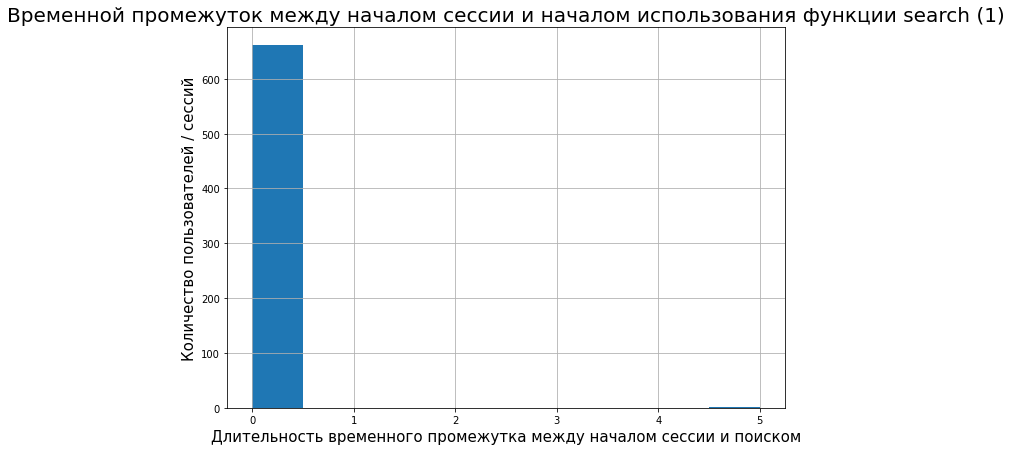

In [127]:
# визуализация распределения количества событий на каждого пользователя

toomuch_sessions_ser['dur_gap'].hist(bins = 10, range = (0, 5))
plt.rcParams["figure.figsize"] = (10, 7)
plt.title('Временной промежуток между началом сессии и началом использования функции search (1)',
          fontsize=20)
plt.xlabel('Длительность временного промежутка между началом сессии и поиском', fontsize=15)
plt.ylabel('Количество пользователей / сессий', fontsize=15)
plt.show()

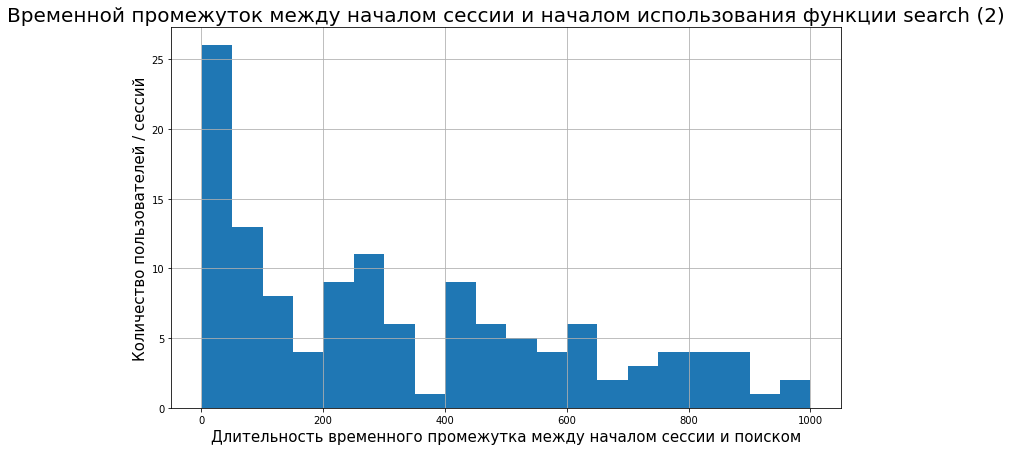

In [131]:
# визуализация распределения количества событий на каждого пользователя

toomuch_sessions_ser['dur_gap'].hist(bins = 20, range = (1, 1000))
plt.rcParams["figure.figsize"] = (10, 7)
plt.title('Временной промежуток между началом сессии и началом использования функции search (2)',
          fontsize=20)
plt.xlabel('Длительность временного промежутка между началом сессии и поиском', fontsize=15)
plt.ylabel('Количество пользователей / сессий', fontsize=15)
plt.show()

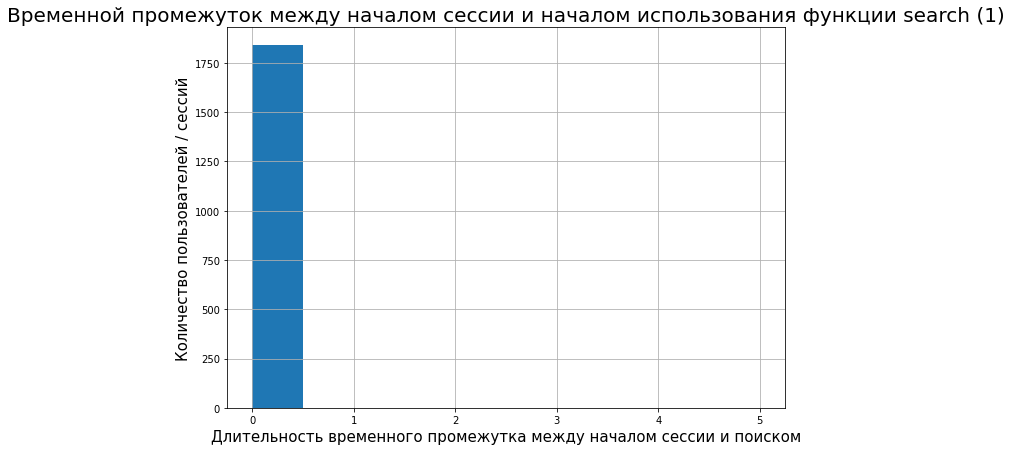

In [125]:
# визуализация распределения количества событий на каждого пользователя

medium_sessions_ser['dur_gap'].hist(bins = 10, range = (0, 5))
plt.rcParams["figure.figsize"] = (10, 7)
plt.title('Временной промежуток между началом сессии и началом использования функции search (1)',
          fontsize=20)
plt.xlabel('Длительность временного промежутка между началом сессии и поиском', fontsize=15)
plt.ylabel('Количество пользователей / сессий', fontsize=15)
plt.show()

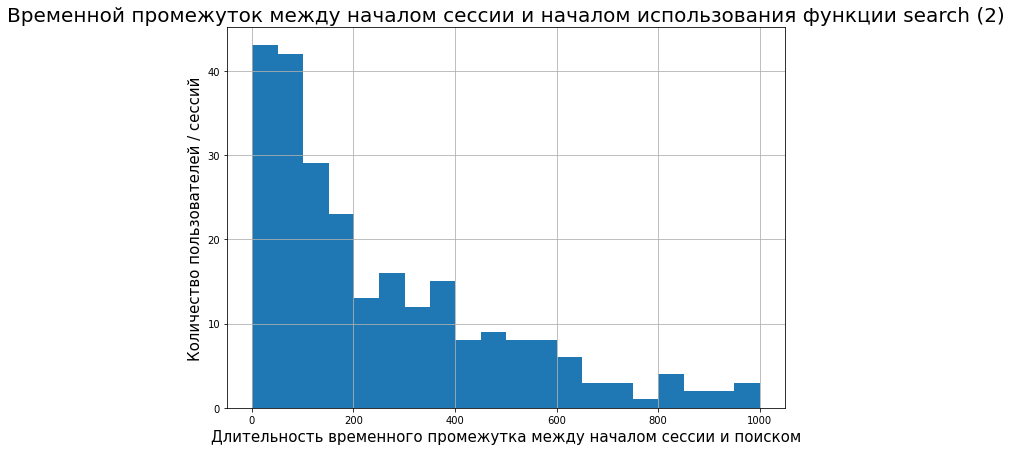

In [130]:
# визуализация распределения количества событий на каждого пользователя

medium_sessions_ser['dur_gap'].hist(bins = 20, range = (1, 1000))
plt.rcParams["figure.figsize"] = (12, 7)
plt.title('Временной промежуток между началом сессии и началом использования функции search (2)',
          fontsize=20)
plt.xlabel('Длительность временного промежутка между началом сессии и поиском', fontsize=15)
plt.ylabel('Количество пользователей / сессий', fontsize=15)
plt.show()

Как видно на гистограммах, количество сессий/рассматриваемых промежутков времени, длительность которых превышает ноль секунд составляет незначительное число от общего количества сессий/временных промежутков. 


Таким образом, делаю вывод: времена между первым действием пользователя в приложении до любого действия из списка событий search_1 — search_7 для пользователей выделенных сегментов не различаются.


_______________________________________________________

________________________________________________________

ИТОГИ РАСЧЁТОВ


Средние значения метрик пользователей, совершивших более 35-ти действий в приложении 
(сегмент toomuch_events):


* Retention Rate (коэффициент удержания) - 59,7%;


* CR (конверсия в целевое действие) - 35,75%;


* Продолжительность сессии - 18 минут 49 секунд;


* 10,6 действий за одну сессию;


* Размер сегмента - 434 пользователя;


* DAU (количество уникальных пользователей в день) - 67;


* WAU (количество уникальных пользователей в неделю) - 206.


Средние значения метрик пользователей, совершивших 35 и менее действий в приложении
(сегмент medium_events):


* Retention Rate (коэффициент удержания) - 18,3%;


* CR (конверсия в целевое действие) - 18,5%;


* Продолжительность сессии - 10 минут 15 секунд;


* 5,6 действий за одну сессию;


* Размер сегмента - 3859 пользователей;


* DAU (количество уникальных пользователей в день) - 212;


* WAU (количество уникальных пользователей в неделю) - 1176.


Результаты расчётов явно показывают, что пользователи, которые совершают необычно много действий в приложении значительно лучше и дольше удерживаются, проводят больше времени в приложении, совершают больше действий  вприложении, чаще заходят в приложение, и значительно чаще совершают целевое действие - просматривают контакты в карточке объявления. По всей видимости, пользователи этого сегмента отличаются большей заинтересованностью и лояльностью к приложению, и увеличение количества действий в приложении явно свидетельствует о заинтересованности пользователя в приложении. 


Таким образом, можно сделать вывод: необычно много действий пользователей в приложении - это обычное поведение именно лояльного заинтересованного пользователя приложения. Расчитанное значение: 35 действий за исследуемый период, как граница аномальной активности пользователей имеет смысл только при расчёте активности всех пользователей, не исключая незаинтересованных пользователей. 


Времена между первым действием пользователя в приложении до любого действия из списка событий search_1 — search_7 для пользователей выделенных сегментов не различаются, и в основной массе составляют ноль секунд.



Далее следует расчёт аномальных показателей активности сегмента toomuch_events.

In [ ]:
# расчёт верхней границы выбросов значений числа событий (действий) пользователя в приложении

q1_t = toomuch_events['user_id'].value_counts().quantile(0.25)
q3_t = toomuch_events['user_id'].value_counts().quantile(0.75)
iqr_t = q3_t - q1_t  
print('Верхняя граница количества событий, выше которой значения признаются выбросами:', 
      (q3_t + 1.5 * iqr_t))

In [ ]:
# расчёт среднего числа событий (действий) пользователя в приложении

toomuch_events['user_id'].value_counts().mean()

In [ ]:
# расчёт среднего числа событий (действий) пользователя в приложении

toomuch_events['user_id'].value_counts().median()

In [ ]:
# визуализация распределения количества событий на каждого пользователя

toomuch_events['user_id'].value_counts().hist(bins = 50, range = (35, 200))
plt.rcParams["figure.figsize"] = (10, 7)
plt.title('Распределение количества событий на каждого пользователя', fontsize=20)
plt.xlabel('Количество событий', fontsize=15)
plt.ylabel('Количество пользователей', fontsize=15)
plt.show()

Верхняя граница количества событий, выше которой значения признаются выбросами для этого сегмента пользователей сильно отличается от аналогичного показателя для общего датасета:  148 действий против 35-ти. Также, сильно отличаются среднее число действий: 77 против 17-ти; медианное число действий: 58 против 9-ти.



# 3 Формулирование и проверка статистических гипотез

Проверка гипотезы №1: пользователи, установившие приложение по ссылке из yandex имеют конверсию в просмотры контактов отличную от конверсии пользователей, установивших приложение по ссылке из google.  

Проверка гипотезы №2: пользователи, установившие приложение по ссылке из yandex проводят в приложении больше времени, чем пользователи, установившие приложение по ссылке из google. 

Для проверки первой гипотезы необходимо выделить пользователей, установивших приложение по ссылке из yandex, и google; выделить из каждой группы доли просмотревших контакты; сравнить доли с помощью z-теста.

In [ ]:
# формирование группы пользователей - пользователи, установившие приложение по ссылке из yandex

yandex_users = dataset.query('source == "yandex"')

yandex_users.head(40)

In [ ]:
# выделение пользователей, совершивших целевое действие

contacts_yandex = yandex_users.query('event_name == "show_contacts"')

# подсчёт количества пользователей, совершивших целевое действие

successes_y = contacts_yandex.groupby('user_id').agg({'user_id': 'unique'}).count()
print('Пользователей, совершивших целевое действие:', successes_y)
print()

# подсчёт общего количества пользователей, установивших приложение по ссылке из yandex

trials_y = yandex_users.groupby('user_id').agg({'user_id': 'unique'}).count()
print('Пользователей, установивших приложение по ссылке из yandex:', trials_y)


In [ ]:
# формирование группы пользователей - пользователи, установившие приложение по ссылке из google

google_users = dataset.query('source == "google"')

google_users.head()

In [ ]:
# выделение пользователей, совершивших целевое действие

contacts_google = google_users.query('event_name == "show_contacts"')

# подсчёт количества пользователей, совершивших целевое действие

successes_g = contacts_google.groupby('user_id').agg({'user_id': 'unique'}).count()
print('Пользователей, совершивших целевое действие:', successes_g)
print()

# подсчёт общего количества пользователей, установивших приложение по ссылке из yandex

trials_g = google_users.groupby('user_id').agg({'user_id': 'unique'}).count()
print('Пользователей, установивших приложение по ссылке из google:', trials_g)


Перед непосредственно проверкой гипотезы необходимо сформулировать нулевую и альтернативную гипотезы. 


Нулевая гипотеза, Н0: 
Пользователи, установившие приложение по ссылке из yandex имеют конверсию в просмотры контактов такую же, что и конверсии пользователей, установивших приложение по ссылке из google.

Альтернативная гипотеза, Н1: 
Пользователи, установившие приложение по ссылке из yandex имеют конверсию в просмотры контактов отличную от конверсии пользователей, установивших приложение по ссылке из google.


In [ ]:
# проверка гипотезы z-тестом

alpha = 0.05
p_y = successes_y/trials_y
p_g = successes_g/trials_g
p_combined = (successes_y + successes_g) / (trials_y + trials_g)
difference = p_y - p_g 

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_y + 1/trials_g))
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2
    
print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


    Проверка гипотезы об отличиях конверсии в просмотры пользователей, установивших приложение по ссылке из yandex или из google дала результат, что отличий в конверсии нет.

_____________________________________________

Для проверки второй гипотезы о разнице в длительности сессий необходимо вычислить длительность сессий, очистить датасеты от выбросов, ...

In [ ]:
# разделение сессий с учётом максимального перерыва между действиями в сессии не более 30 минут

g_yandex = (yandex_users.groupby('user_id')['event_time'].diff() > pd.Timedelta('30Min')).cumsum()

yandex_users['session_id'] = yandex_users.groupby(['user_id', g_yandex], sort=False).ngroup() + 1

# вывод большого числа строк для визуального контроля отделения сессий 

yandex_users.head(50)

In [ ]:
# вычисление времени начала сессий

s_yandex = yandex_users.groupby('session_id').agg({'event_time' : 'min'}).reset_index()
s_yandex = s_yandex.rename(columns={'event_time': 'start_session'}) 
s_yandex.head(3)

In [ ]:
# вычисление времени окончания сессий

e_yandex = yandex_users.groupby('session_id').agg({'event_time' : 'max'}).reset_index()
e_yandex = e_yandex.rename(columns={'event_time': 'end_session'}) 
e_yandex.head(3)

In [ ]:
# объединение датафреймов, содержащих даты начала и окончания сессий

yandex_sessions = s_yandex.merge(e_yandex, on = 'session_id')

yandex_sessions.head(3)

In [ ]:
# вычисление длительности сессий в секундах

yandex_sessions['dur_sess'] = yandex_sessions['end_session'] - yandex_sessions['start_session']
yandex_sessions['dur_sess'] = yandex_sessions['dur_sess'].dt.seconds

yandex_sessions.head(3)

In [ ]:
# разделение сессий с учётом максимального перерыва между действиями в сессии не более 30 минут

g_google = (google_users.groupby('user_id')['event_time'].diff() > pd.Timedelta('30Min')).cumsum()

google_users['session_id'] = google_users.groupby(['user_id', g_google], sort=False).ngroup() + 1

# вывод большого числа строк для визуального контроля отделения сессий 

google_users.head(50)

In [ ]:
# вычисление времени начала сессий

s_google = google_users.groupby('session_id').agg({'event_time' : 'min'}).reset_index()
s_google = s_google.rename(columns={'event_time': 'start_session'}) 
s_google.head(3)

In [ ]:
# вычисление времени окончания сессий

e_google = google_users.groupby('session_id').agg({'event_time' : 'max'}).reset_index()
e_google = e_google.rename(columns={'event_time': 'end_session'}) 
e_google.head(3)

In [ ]:
# объединение датафреймов, содержащих даты начала и окончания сессий

google_sessions = s_google.merge(e_google, on = 'session_id')

google_sessions.head(3)

In [ ]:
# вычисление длительности сессий в секундах

google_sessions['dur_sess'] = google_sessions['end_session'] - google_sessions['start_session']
google_sessions['dur_sess'] = google_sessions['dur_sess'].dt.seconds

google_sessions.head(3)

In [ ]:
# просмотр агрегтированных данных о времени сессий пользователей, 
# установивших приложение по ссылке из yandex

yandex_sessions['dur_sess'].describe()

In [ ]:
# определение 95 и 99 перцентилей среди значений длительности сессий пользователей, 
# установивших приложение по ссылке из yandex

print(np.percentile(yandex_sessions['dur_sess'], [95, 99])) 

In [ ]:
# просмотр агрегированных данных о длительности сессий пользователей, 
# установивших приложение по ссылке из google

google_sessions['dur_sess'].describe()

In [ ]:
# определение 95 и 99 перцентилей среди значений длительности сессий пользователей, 
# установивших приложение по ссылке из google

print(np.percentile(google_sessions['dur_sess'], [95, 99])) 

По результатам вычисления 95 и 99 перцентилей среди значений длительности сессий пользователей, решаю отсечь сессии, длительность которых превышает значение 95 перцентиля для каждой группы пользователей.


В дальнейшем исследовании не рассматриваю сессии пользователей, установивших приложение по ссылке из yandex, длительностью более 1035 секунд.


Также, в дальнейшем исследовании не рассматриваю сессии пользователей, установивших приложение по ссылке из google, длительностью более 1305.85 секунд.


In [ ]:
yandex_sessions_n = yandex_sessions.query('dur_sess <= 1035')
yandex_sessions_n['dur_sess'].describe()

In [ ]:
google_sessions_n = google_sessions.query('dur_sess <= 1305.85')
google_sessions_n['dur_sess'].describe()

Оба датасета очищены от выбросов. Далее нужно сформулировать нулевую и альтернативную гипотезы и проверить гипотезу как  гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.


Нулевая гипотеза, Н0: 
Пользователи, установившие приложение по ссылке из yandex и пользователи, установившие приложение по ссылке из google проводят в приложении равное количество времени.

Альтернативная гипотеза, Н1: 
Пользователи, установившие приложение по ссылке из yandex и пользователи, установившие приложение по ссылке из google проводят в приложении разное количество времени.


In [ ]:
# проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам

sample_1 = yandex_sessions_n['dur_sess']
sample_2 = google_sessions_n['dur_sess']

alpha = 0.05

results = st.ttest_ind(sample_1, sample_2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Полученное значение p-value говорит о том, что пользователи, установившие приложение по ссылке из yandex и пользователи, установившие приложение по ссылке из google проводят в приложении разное количество времени. 


Учитывая ранее расчитанные агрегированные данные о времени сессий пользователей, можно сделать вывод о том, что именно пользователи установившие приложение по ссылке из google проводят в приложении больше времени, чем пользователи установившие приложение по ссылке из yandex.

# 4 Выводы
Формулировка выводов по результатам выделения групп пользователей и проверки статистических гипотез. Возможные рекомендации по взаимодействию с выделенными пользовательскими группами. Ссылка на презентацию и дашборд.

Выделение группы пользователей по количеству совершённых ими действий в приложении оказалось результативным. Как показали расчёты, большое число и частота действий пользователей в приложении свидетельствуют о заинтересованности пользователей, вовлечённости и высокой конверсии их действий в целевое действие. 


Для увеличения и стабильного удержания пользователей в приложении, возможно, имеет смысл поощрать пользователей чаще заходить в приложение, совершать больше активностей, тем самым вовлекая пользователей. Такое вовлечение пользователей, вероятно может сподвигнуть пользователя совершить целевые действия.


Расчёты показали, что времена между первым действием пользователя в приложении до любого действия из списка событий search_1 — search_7 для пользователей выделенных сегментов не различаются, и в основной массе составляют ноль секунд.


Были проверены две гипотезы.
Выяснено, что отличий в конверсии в целевое действие, у пользователей установивших приложение по ссылке из yandex или из google нет.
Однако, при этом, выяснено, что пользователи, установившие приложение по ссылке из google проводят в приложении больше времени, чем пользователи, установившие приложение по ссылке из yandex. 


С учётом результатов исследования с разделением пользователей на группы по количеству их действий в приложении, можно предположить, что само время проведённое в приложении не играет решающей роли на конверсию в целевое действие, а более весомым фактором, вероятно, является количество действий в приложении. 


